In [ ]:
# %%
# ==========================================
# 0. IMPORTS & SETUP
# ==========================================
import os
import datetime
import pickle
import warnings
import logging  # <--- NEW: The Logging Module
import numpy as np
import pandas as pd
import scanpy as sc
import dask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from joblib import Parallel, delayed
import mesa

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
dask.config.set({"dataframe.query-planning": True})

# --- CONFIGURATION ---
INPUT_FILE = "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Kidney_ST/GSE211785_7_13_23_slide0_annotated_iPTsubclusters.h5ad"
N_REPLICATES = 50
NUM_CORES = 100
GRID_SIZE = 60

# Create Output Directory
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = f"./simulation_results_{timestamp}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- LOGGING CONFIGURATION (NEW) ---
log_filename = os.path.join(OUTPUT_DIR, 'execution.log')

# Setup logger
logger = logging.getLogger('KidneySim')
logger.setLevel(logging.INFO)

# 1. File Handler (Writes to disk)
file_handler = logging.FileHandler(log_filename)
file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(file_formatter)
logger.addHandler(file_handler)

# 2. Stream Handler (Writes to screen)
console_handler = logging.StreamHandler()
console_handler.setFormatter(file_formatter)
logger.addHandler(console_handler)

logger.info("--- SIMULATION PIPELINE INITIALIZED ---")
logger.info(f"Output Directory: {OUTPUT_DIR}")
logger.info(
    f"Configuration: {N_REPLICATES} replicates, {NUM_CORES} cores, Grid {GRID_SIZE}x{GRID_SIZE}")

# ==========================================
# 1. LOAD DATA
# ==========================================
logger.info(f"Loading input data from: {INPUT_FILE}")
try:
    adata = sc.read_h5ad(INPUT_FILE)
    logger.info(
        f"Successfully loaded AnnData object with shape: {adata.shape}")
except FileNotFoundError:
    logger.error(f"File not found: {INPUT_FILE}")
    raise

# Fix Spatial Coordinates
if hasattr(adata.obsm['spatial'], 'to_numpy'):
    logger.info("Converting spatial coordinates to Numpy array...")
    adata.obsm['spatial'] = adata.obsm['spatial'].to_numpy()
elif not isinstance(adata.obsm['spatial'], np.ndarray):
    adata.obsm['spatial'] = np.array(adata.obsm['spatial'])

# ==========================================
# 2. DEFINE SIMULATION CLASSES
# ==========================================


class KidneyAgent(mesa.Agent):
    def __init__(self, model, pos, cell_type):
        super().__init__(model)
        self.pos = pos
        self.cell_type = cell_type
        self.is_immune = ('Immune' in self.cell_type)
        self.is_source = any(t in self.cell_type for t in [
                             'Injured TAL', 'iPT_1', 'iPT_2'])

    def step(self):
        if self.is_source:
            x, y = self.pos
            self.model.chemokine_layer[x][y] += 1.0
        if self.is_immune:
            self.move_chemotactically()

    def move_chemotactically(self):
        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False)
        best_pos = self.pos
        best_signal = self.model.chemokine_layer[self.pos[0]][self.pos[1]]

        for pos in neighbors:
            signal = self.model.chemokine_layer[pos[0]][pos[1]]
            if signal > best_signal:
                best_signal = signal
                best_pos = pos

        if best_pos != self.pos:
            self.model.grid.move_agent(self, best_pos)
        else:
            self.model.grid.move_agent(self, self.random.choice(neighbors))


class KidneyModel(mesa.Model):
    def __init__(self, df, seed=None):
        super().__init__()
        if seed is not None:
            self.random.seed(seed)
            np.random.seed(seed)

        self.grid = mesa.space.MultiGrid(GRID_SIZE, GRID_SIZE, torus=False)
        self.chemokine_layer = np.zeros((GRID_SIZE, GRID_SIZE))

        for idx, row in df.iterrows():
            a = KidneyAgent(self, (row['gx'], row['gy']), row['CellType'])
            self.grid.place_agent(a, (row['gx'], row['gy']))
            self.agents.add(a)

    def step(self):
        self.agents.shuffle().do("step")
        self.chemokine_layer *= 0.85
        self.chemokine_layer = gaussian_filter(self.chemokine_layer, sigma=0.7)

# ==========================================
# 3. WORKER & PREP FUNCTIONS
# ==========================================


def run_single_simulation(df, steps=30, seed=None):
    # Note: Logging inside workers can be tricky with parallel processing.
    # We keep it simple here or rely on the main process to track progress.
    try:
        model = KidneyModel(df, seed)
        for _ in range(steps):
            model.step()
        return [a.pos for a in model.agents if a.is_immune]
    except Exception as e:
        # If a worker fails, we want to know why!
        return f"ERROR: {str(e)}"


def prepare_df(adata, condition, grid_size):
    logger.info(f"Preparing dataframe for condition: {condition}")
    df = pd.DataFrame({
        'x': adata.obs['x_slide_mm'],
        'y': adata.obs['y_slide_mm'],
        'CellType': adata.obs['cellType_CosMx_2'].astype(str),
        'Condition': adata.obs['type']
    })
    df = df[df['Condition'] == condition].copy()

    x_range = df['x'].max() - df['x'].min()
    y_range = df['y'].max() - df['y'].min()
    if x_range == 0:
        x_range = 1
    if y_range == 0:
        y_range = 1

    scale_factor = (grid_size - 1) / max(x_range, y_range)
    df['gx'] = ((df['x'] - df['x'].min()) * scale_factor).astype(int)
    df['gy'] = ((df['y'] - df['y'].min()) * scale_factor).astype(int)
    return df

# ==========================================
# 4. EXECUTION
# ==========================================


df_healthy = prepare_df(adata, 'Healthy', GRID_SIZE)
df_disease = prepare_df(adata, 'Disease', GRID_SIZE)

logger.info("--- STARTING PARALLEL EXECUTION ---")
logger.info(f"Dispatching to {NUM_CORES} cores...")

tasks = []
for i in range(N_REPLICATES):
    tasks.append(('Healthy', df_healthy, i))
    tasks.append(('Disease', df_disease, i + 1000))

# Execute
start_time = datetime.datetime.now()
results = Parallel(n_jobs=NUM_CORES, verbose=5)(  # Verbose=5 gives joblib progress bars
    delayed(run_single_simulation)(df, steps=30, seed=seed)
    for condition, df, seed in tasks
)
end_time = datetime.datetime.now()
duration = end_time - start_time

logger.info(f"Simulation completed in {duration}")

# Organize Results & Check for Errors
results_dict = {'Healthy': [], 'Disease': []}
error_count = 0

for i, task in enumerate(tasks):
    cond = task[0]
    res = results[i]

    if isinstance(res, str) and res.startswith("ERROR"):
        logger.error(f"Run {i} failed: {res}")
        error_count += 1
    else:
        results_dict[cond].append(res)

if error_count > 0:
    logger.warning(f"Completed with {error_count} errors.")
else:
    logger.info("All runs completed successfully.")

# ==========================================
# 5. SAVE INTERMEDIATE FILES
# ==========================================
logger.info("Saving raw data to pickle...")
pkl_path = os.path.join(OUTPUT_DIR, 'simulation_data_raw.pkl')
with open(pkl_path, 'wb') as f:
    pickle.dump(results_dict, f)
logger.info(f"Data saved: {pkl_path}")

# ==========================================
# 6. VISUALIZATION
# ==========================================
logger.info("Generating plots...")
fig, axes = plt.subplots(1, 2, figsize=(16, 7))


def plot_prob_density(ax, pos_list_of_lists, title):
    if not pos_list_of_lists:
        logger.warning(f"No data to plot for {title}")
        return

    all_x = []
    all_y = []
    for run in pos_list_of_lists:
        for (x, y) in run:
            all_x.append(x)
            all_y.append(y)

    hb = ax.hexbin(all_x, all_y, gridsize=40,
                   cmap='inferno', mincnt=1, bins='log')
    ax.invert_yaxis()
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_facecolor('black')
    return hb


plot_prob_density(axes[0], results_dict['Healthy'],
                  f"Healthy (n={len(results_dict['Healthy'])})")
plot_prob_density(axes[1], results_dict['Disease'],
                  f"Disease (n={len(results_dict['Disease'])})")

plt.suptitle(
    "Sensitivity Analysis: Aggregate Immune Probability Density", fontsize=18)
plt.tight_layout()

img_path = os.path.join(OUTPUT_DIR, 'density_map_HPC_run.png')
plt.savefig(img_path, dpi=300)
logger.info(f"Plot saved: {img_path}")

# Done
logger.info("--- PIPELINE FINISHED EXECUTING ---")
# Close handlers to release file lock
logger.handlers.clear()
plt.show()


Loading /mnt/home3/miska/nm667/scratch/inProgress/dev/simulation_results_20251203_091245/simulation_data_raw.pkl...
Loaded Healthy Runs: 50
Loaded Disease Runs: 50


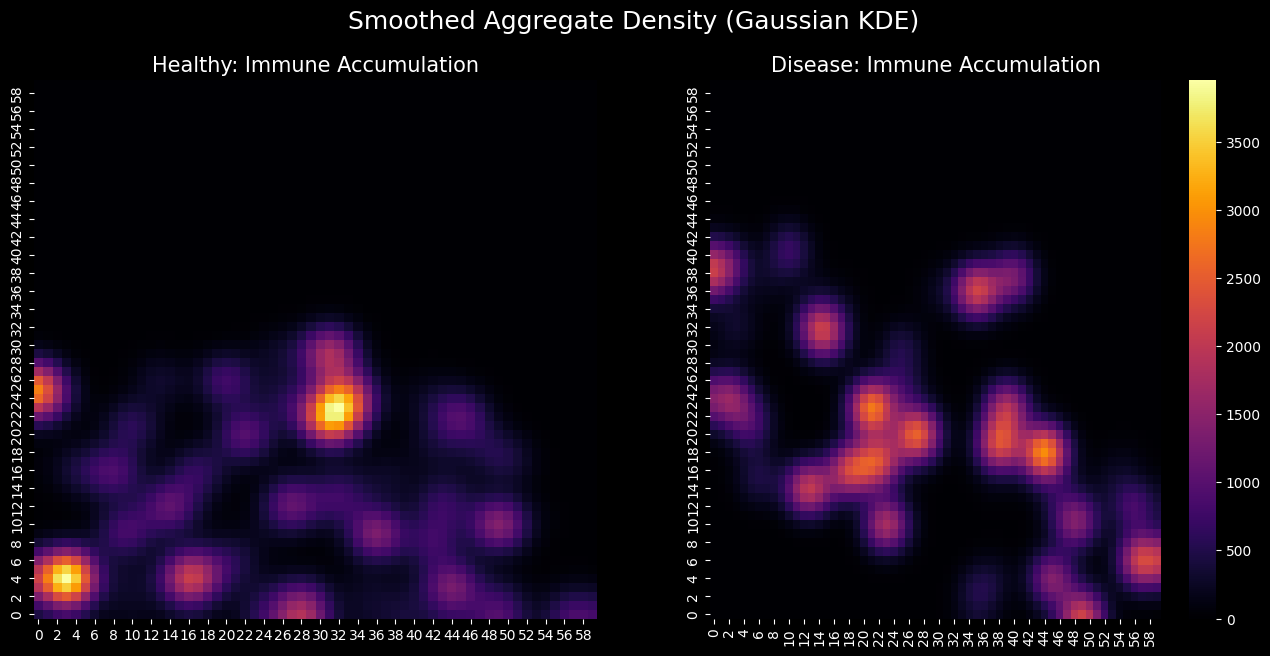

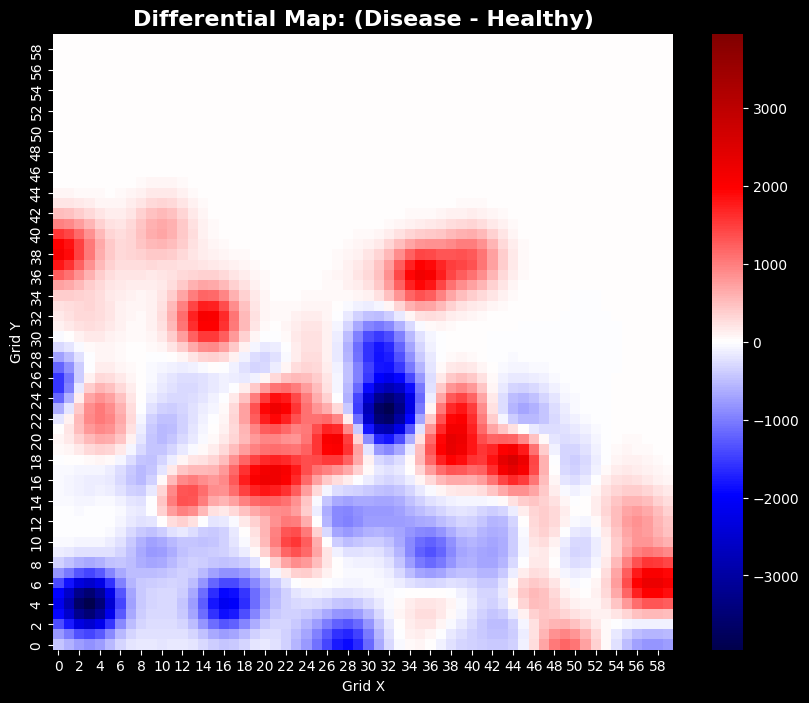

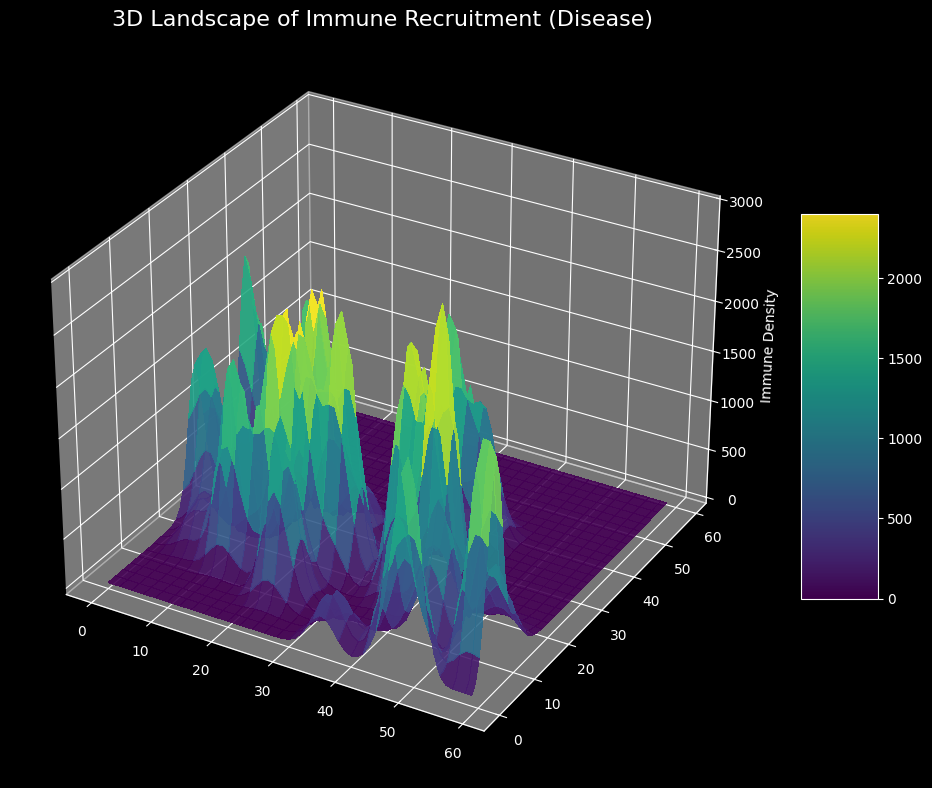

In [2]:
from matplotlib import cm
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter

# ==========================================
# 1. CONFIGURATION & LOAD
# ==========================================
# Update this to your specific timestamp folder
PICKLE_FILE = "/mnt/home3/miska/nm667/scratch/inProgress/dev/simulation_results_20251203_091245/simulation_data_raw.pkl"
GRID_SIZE = 60  # Must match your simulation grid size

print(f"Loading {PICKLE_FILE}...")
with open(PICKLE_FILE, 'rb') as f:
    results = pickle.load(f)

print(f"Loaded Healthy Runs: {len(results['Healthy'])}")
print(f"Loaded Disease Runs: {len(results['Disease'])}")

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================


def flatten_coordinates(run_list):
    """Converts list of lists of (x,y) into two flat arrays."""
    x_flat = []
    y_flat = []
    for run in run_list:
        for (x, y) in run:
            x_flat.append(x)
            y_flat.append(y)
    return np.array(x_flat), np.array(y_flat)


def generate_density_matrix(run_list, grid_size, sigma=2.0):
    """Creates a 2D smoothed density matrix from coordinates."""
    x, y = flatten_coordinates(run_list)

    # Create 2D histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=grid_size, range=[
                                             [0, grid_size], [0, grid_size]])

    # Transpose to match Cartesian coords (otherwise x/y flip)
    heatmap = heatmap.T

    # Apply Gaussian smoothing for a "Heatmap" look
    heatmap_smooth = gaussian_filter(heatmap, sigma=sigma)
    return heatmap_smooth


# Generate matrices
h_matrix = generate_density_matrix(results['Healthy'], GRID_SIZE, sigma=2.0)
d_matrix = generate_density_matrix(results['Disease'], GRID_SIZE, sigma=2.0)

# Calculate global max for consistent color scaling
global_max = max(h_matrix.max(), d_matrix.max())

# ==========================================
# 3. PLOT 1: SMOOTHED DENSITY COMPARISON
# ==========================================
fig1, ax = plt.subplots(1, 2, figsize=(16, 7))

# Plot Healthy
sns.heatmap(h_matrix, ax=ax[0], cmap='inferno',
            vmin=0, vmax=global_max, cbar=False)
ax[0].set_title('Healthy: Immune Accumulation', fontsize=15)
ax[0].invert_yaxis()  # Fix origin to bottom-left

# Plot Disease
im = sns.heatmap(d_matrix, ax=ax[1], cmap='inferno',
                 vmin=0, vmax=global_max, cbar=True)
ax[1].set_title('Disease: Immune Accumulation', fontsize=15)
ax[1].invert_yaxis()

plt.suptitle("Smoothed Aggregate Density (Gaussian KDE)", fontsize=18)
plt.show()

# ==========================================
# 4. PLOT 2: THE DIFFERENTIAL MAP (Subtraction)
# ==========================================
# This is the most scientifically valuable plot.
# Red = Areas where Disease causes MORE immune cells
# Blue = Areas where Disease causes FEWER immune cells (or Healthy has more)

diff_matrix = d_matrix - h_matrix
limit = max(abs(diff_matrix.min()), abs(
    diff_matrix.max()))  # Center colorbar at 0

fig2, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(diff_matrix, cmap='seismic', center=0,
            vmin=-limit, vmax=limit, ax=ax)

ax.invert_yaxis()
ax.set_title("Differential Map: (Disease - Healthy)",
             fontsize=16, fontweight='bold')
ax.set_xlabel("Grid X")
ax.set_ylabel("Grid Y")

plt.show()

# ==========================================
# 5. PLOT 3: 3D SURFACE PLOT
# ==========================================
# Great for showing "Peaks" of recruitment


fig3, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 10))

X = np.arange(0, GRID_SIZE, 1)
Y = np.arange(0, GRID_SIZE, 1)
X, Y = np.meshgrid(X, Y)

# Plotting the Disease surface
surf = ax.plot_surface(X, Y, d_matrix, cmap='viridis',
                       linewidth=0, antialiased=False, alpha=0.9)

ax.set_title("3D Landscape of Immune Recruitment (Disease)", fontsize=16)
ax.set_zlabel("Immune Density")
fig3.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [13]:
import os
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy.stats import ttest_ind

# ==========================================
# 1. CONFIGURATION
# ==========================================
# --- PATHS ---
PICKLE_FILE = "/mnt/home3/miska/nm667/scratch/inProgress/dev/simulation_results_20251203_091245/simulation_data_raw.pkl"
INPUT_FILE = "../../data/Kidney_ST/Kidney_CosMx_BANKSY_Calculated.h5ad"
OUTPUT_DIR = "../../analysis/agentModeling"

# --- PARAMETERS ---
GRID_SIZE = 60
SIGMA = 2.0
CELL_TYPE_KEY = 'cellType_CosMx_2'  # Detailed cell types
DOMAIN_KEY = 'BANKSY_Domain'        # Spatial domains
CONDITION_KEY = 'type'              # Healthy vs Disease

# --- VISUALIZATION THEME ---
os.makedirs(OUTPUT_DIR, exist_ok=True)
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.4)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['pdf.fonttype'] = 42
sc.set_figure_params(dpi=300, facecolor='white', vector_friendly=True)

print(f"--- INITIALIZING ATLAS PIPELINE ---")
print(f"Output Directory: {OUTPUT_DIR}")


def save_output(name, df=None):
    """Helper to save PDF, PNG, and CSV data."""
    plt.savefig(f"{OUTPUT_DIR}/{name}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{OUTPUT_DIR}/{name}.pdf", bbox_inches='tight')
    if df is not None:
        df.to_csv(f"{OUTPUT_DIR}/{name}.csv")
    print(f"Saved: {name}")


# ==========================================
# 2. LOAD DATA & CALCULATE SCORES
# ==========================================
print("Loading AnnData...")
adata = sc.read_h5ad(INPUT_FILE)

print("Loading Simulation Results...")
with open(PICKLE_FILE, 'rb') as f:
    results = pickle.load(f)

# FIX: Ensure Spatial Coordinates are NumPy array
if isinstance(adata.obsm['spatial'], pd.DataFrame):
    print("Fixing spatial coordinates format...")
    adata.obsm['spatial'] = adata.obsm['spatial'].to_numpy()

coords = adata.obsm['spatial']
x_real = coords[:, 0]
y_real = coords[:, 1]

print("Calculating Grid Density Scores...")


def get_density(run_list):
    all_x = [p[0] for run in run_list for p in run]
    all_y = [p[1] for run in run_list for p in run]
    heatmap, _, _ = np.histogram2d(all_x, all_y, bins=GRID_SIZE, range=[
                                   [0, GRID_SIZE], [0, GRID_SIZE]])
    return gaussian_filter(heatmap.T, sigma=SIGMA)


grid_h = get_density(results['Healthy'])
grid_d = get_density(results['Disease'])
grid_diff = grid_d - grid_h

# Map Grid Scores to Cells
print("Mapping scores to single cells...")
scale = (GRID_SIZE - 1) / max((x_real.max() - x_real.min()),
                              (y_real.max() - y_real.min()))
gx = np.clip(((x_real - x_real.min()) * scale).astype(int), 0, GRID_SIZE - 1)
gy = np.clip(((y_real - y_real.min()) * scale).astype(int), 0, GRID_SIZE - 1)

# Differential (Disease - Healthy)
adata.obs['Recruitment_Score'] = grid_diff[gx, gy]
# Absolute (Disease Only)
adata.obs['Sim_Score_Disease'] = grid_d[gx, gy]

# ==========================================
# 3. GENERATE FIGURES
# ==========================================

# --- FIG 01: DISEASE ZOOM (The "Hotspots") ---
print("Generating Fig 01: Disease Zoom Maps...")
subset = adata[adata.obs[CONDITION_KEY] == 'Disease'].copy()
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# 1A: Absolute Density
sc.pl.embedding(subset, basis='spatial', color='Sim_Score_Disease',
                cmap='inferno', size=15, title='1A. Simulated Immune Density (Absolute)',
                frameon=False, ax=ax[0], show=False)

# 1B: Differential Score
max_val = np.max(np.abs(subset.obs['Recruitment_Score']))
sc.pl.embedding(subset, basis='spatial', color='Recruitment_Score',
                cmap='vlag', vmin=-max_val, vmax=max_val, size=15,
                title='1B. Maladaptive Niche (Disease - Healthy)',
                frameon=False, ax=ax[1], show=False)

plt.tight_layout()
save_output("Fig01_Disease_Zoom_Maps", subset.obs[[
            'x_slide_mm', 'y_slide_mm', 'Recruitment_Score']])
plt.close()


# --- FIG 02: WHOLE SLIDE ARCHITECTURE ---
print("Generating Fig 02: Whole Slide Maps...")
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# 2A: Tissue Architecture (Top 15 Cell Types)
top_cells = adata.obs[CELL_TYPE_KEY].value_counts().index[:15]
adata.obs['Plot_Cells'] = adata.obs[CELL_TYPE_KEY].apply(
    lambda x: x if x in top_cells else 'Other')

sc.pl.embedding(adata, basis='spatial', color='Plot_Cells',
                title="2A. Tissue Architecture", palette='tab20', size=5,
                frameon=False, ax=ax[0], show=False)

# 2B: Recruitment Hotspots (Global)
sc.pl.embedding(adata, basis='spatial', color='Recruitment_Score',
                title="2B. Immune Recruitment Hotspots",
                cmap='vlag', vmin=-max_val, vmax=max_val, size=5,
                frameon=False, ax=ax[1], show=False)

plt.tight_layout()
save_output("Fig02_WholeSlide_Architecture", adata.obs[[
            'x_slide_mm', 'y_slide_mm', 'Plot_Cells', 'Recruitment_Score']])
plt.close()


# --- FIG 03: CELL TYPE RANKING ---
print("Generating Fig 03: Cell Type Ranking...")
ranking = adata.obs.groupby(CELL_TYPE_KEY)[
    'Recruitment_Score'].mean().sort_values(ascending=False)
df_rank = pd.DataFrame(
    {'Cell_Type': ranking.index, 'Mean_Score': ranking.values})

plt.figure(figsize=(12, 10))
sns.barplot(data=df_rank, x='Mean_Score', y='Cell_Type',
            palette='viridis', hue='Cell_Type', legend=False)

plt.title("3. Which Cell Types Attract Immune Cells?", fontsize=16)
plt.xlabel("Mean Recruitment Score (Positive = Attractive)", fontsize=12)
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()

save_output("Fig03_CellType_Ranking", df_rank)
plt.close()


# --- FIG 04: GLOBAL STATS (Healthy vs Disease) ---
print("Generating Fig 04: Global Statistics...")
df_cond = adata.obs[[CONDITION_KEY, 'Recruitment_Score']].copy()
t_stat, p_val = ttest_ind(
    df_cond[df_cond[CONDITION_KEY] == 'Disease']['Recruitment_Score'],
    df_cond[df_cond[CONDITION_KEY] == 'Healthy']['Recruitment_Score'],
    alternative='greater'
)

plt.figure(figsize=(8, 6))
# Added hue=CONDITION_KEY and legend=False to fix deprecated warning
sns.violinplot(data=df_cond, x=CONDITION_KEY, y='Recruitment_Score', hue=CONDITION_KEY, legend=False,
               palette={'Healthy': 'tab:blue', 'Disease': 'tab:red'}, inner='box')

plt.title(
    f"4. Global Recruitment: Healthy vs Disease\n(p={p_val:.2e})", fontsize=16)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)

save_output("Fig04_Global_Stats", df_cond)
plt.close()


# --- FIG 05: BANKSY INTERACTION ---
print("Generating Fig 05: BANKSY Domains Interaction...")
if DOMAIN_KEY in adata.obs:
    df_inter = adata.obs[[DOMAIN_KEY,
                          CONDITION_KEY, 'Recruitment_Score']].copy()
    df_inter[DOMAIN_KEY] = df_inter[DOMAIN_KEY].astype(str)

    # Sort domains by median recruitment activity
    order = df_inter.groupby(DOMAIN_KEY)['Recruitment_Score'].median(
    ).sort_values(ascending=False).index

    plt.figure(figsize=(16, 8))
    sns.boxplot(
        data=df_inter, x=DOMAIN_KEY, y='Recruitment_Score',
        hue=CONDITION_KEY, order=order,
        palette={'Healthy': 'lightblue', 'Disease': 'red'},
        fliersize=1
    )

    plt.title("5. Impact of Disease on Spatial Domains (BANKSY)", fontsize=18)
    plt.xlabel("BANKSY Spatial Domain", fontsize=14)
    plt.ylabel("Recruitment Score", fontsize=14)
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.legend(title="Condition")
    plt.tight_layout()

    save_output("Fig05_BANKSY_Interaction", df_inter)
    plt.close()
else:
    print(f"Skipping Fig 05: '{DOMAIN_KEY}' not found.")


# --- FIG 06: CELL TYPE INTERACTION (Split Boxplot) ---
print("Generating Fig 06: Cell Type Interaction...")
# Filter to Top 20 Cell Types to avoid overcrowding
top_n = 20
top_cells_inter = adata.obs[CELL_TYPE_KEY].value_counts().head(top_n).index
df_cell_inter = adata.obs[adata.obs[CELL_TYPE_KEY].isin(
    top_cells_inter)].copy()

# Sort by Disease Recruitment Score
order_cells = df_cell_inter[df_cell_inter[CONDITION_KEY] == 'Disease'].groupby(
    CELL_TYPE_KEY)['Recruitment_Score'].median().sort_values(ascending=False).index

plt.figure(figsize=(18, 10))
sns.boxplot(
    data=df_cell_inter, x=CELL_TYPE_KEY, y='Recruitment_Score',
    hue=CONDITION_KEY, order=order_cells,
    palette={'Healthy': 'lightblue', 'Disease': 'red'},
    showfliers=False  # Hide outliers for cleaner view
)

plt.title(f"6. Impact of Disease on Cell Types (Top {top_n})", fontsize=18)
plt.xlabel("Cell Type", fontsize=14)
plt.ylabel("Recruitment Score", fontsize=14)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Condition", loc='upper right')
plt.tight_layout()

save_output("Fig06_CellType_Interaction", df_cell_inter[[
            CELL_TYPE_KEY, CONDITION_KEY, 'Recruitment_Score']])
plt.close()

print("--- ALL ANALYSIS COMPLETED SUCCESSFULLY ---")


--- INITIALIZING ATLAS PIPELINE ---
Output Directory: ../../analysis/agentModeling
Loading AnnData...


Loading Simulation Results...
Calculating Grid Density Scores...
Mapping scores to single cells...
Generating Fig 01: Disease Zoom Maps...
Saved: Fig01_Disease_Zoom_Maps
Generating Fig 02: Whole Slide Maps...
Saved: Fig02_WholeSlide_Architecture
Generating Fig 03: Cell Type Ranking...


/tmp/ipykernel_1854637/2417426814.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ranking = adata.obs.groupby(CELL_TYPE_KEY)[


Saved: Fig03_CellType_Ranking
Generating Fig 04: Global Statistics...
Saved: Fig04_Global_Stats
Generating Fig 05: BANKSY Domains Interaction...
Saved: Fig05_BANKSY_Interaction
Generating Fig 06: Cell Type Interaction...


/tmp/ipykernel_1854637/2417426814.py:229: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order_cells = df_cell_inter[df_cell_inter[CONDITION_KEY] == 'Disease'].groupby(


Saved: Fig06_CellType_Interaction
--- ALL ANALYSIS COMPLETED SUCCESSFULLY ---
